In [1]:
import tensorflow as tf
from flow_models import *
from model_trainer_half import *
from flow_check_model import FlowModel
from tensorflow.keras import mixed_precision
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [3]:
vid_dir = Path('data/cut')
vid_paths = [str(vid_dir/vn) for vn in os.listdir(vid_dir)]

In [4]:
val_ds = create_train_dataset(vid_paths, (320,320), 1, True, parallel=1)

In [5]:
frame_size = (320,320)
interp_ratio = [0.5]
model_f = ehrb0_143_32
weight_dir = 'savedmodels/ehrb0_100/2'

In [6]:
inputs = tf.keras.Input((frame_size[1],frame_size[0],6))
flow_model = FlowModel(inputs, model_f, interp_ratio)
flow_model.load_weights(weight_dir)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 320, 320, 6)]     0         
_________________________________________________________________
EffHRNetB0 (EfficientHRNet_B (None, 160, 160, 32)      16633961  
_________________________________________________________________
upscale_block (Sequential)   (None, 320, 320, 32)      18752     
_________________________________________________________________
activation (Activation)      (None, 320, 320, 32)      0         
Total params: 16,652,713
Trainable params: 16,592,188
Non-trainable params: 60,525
_________________________________________________________________


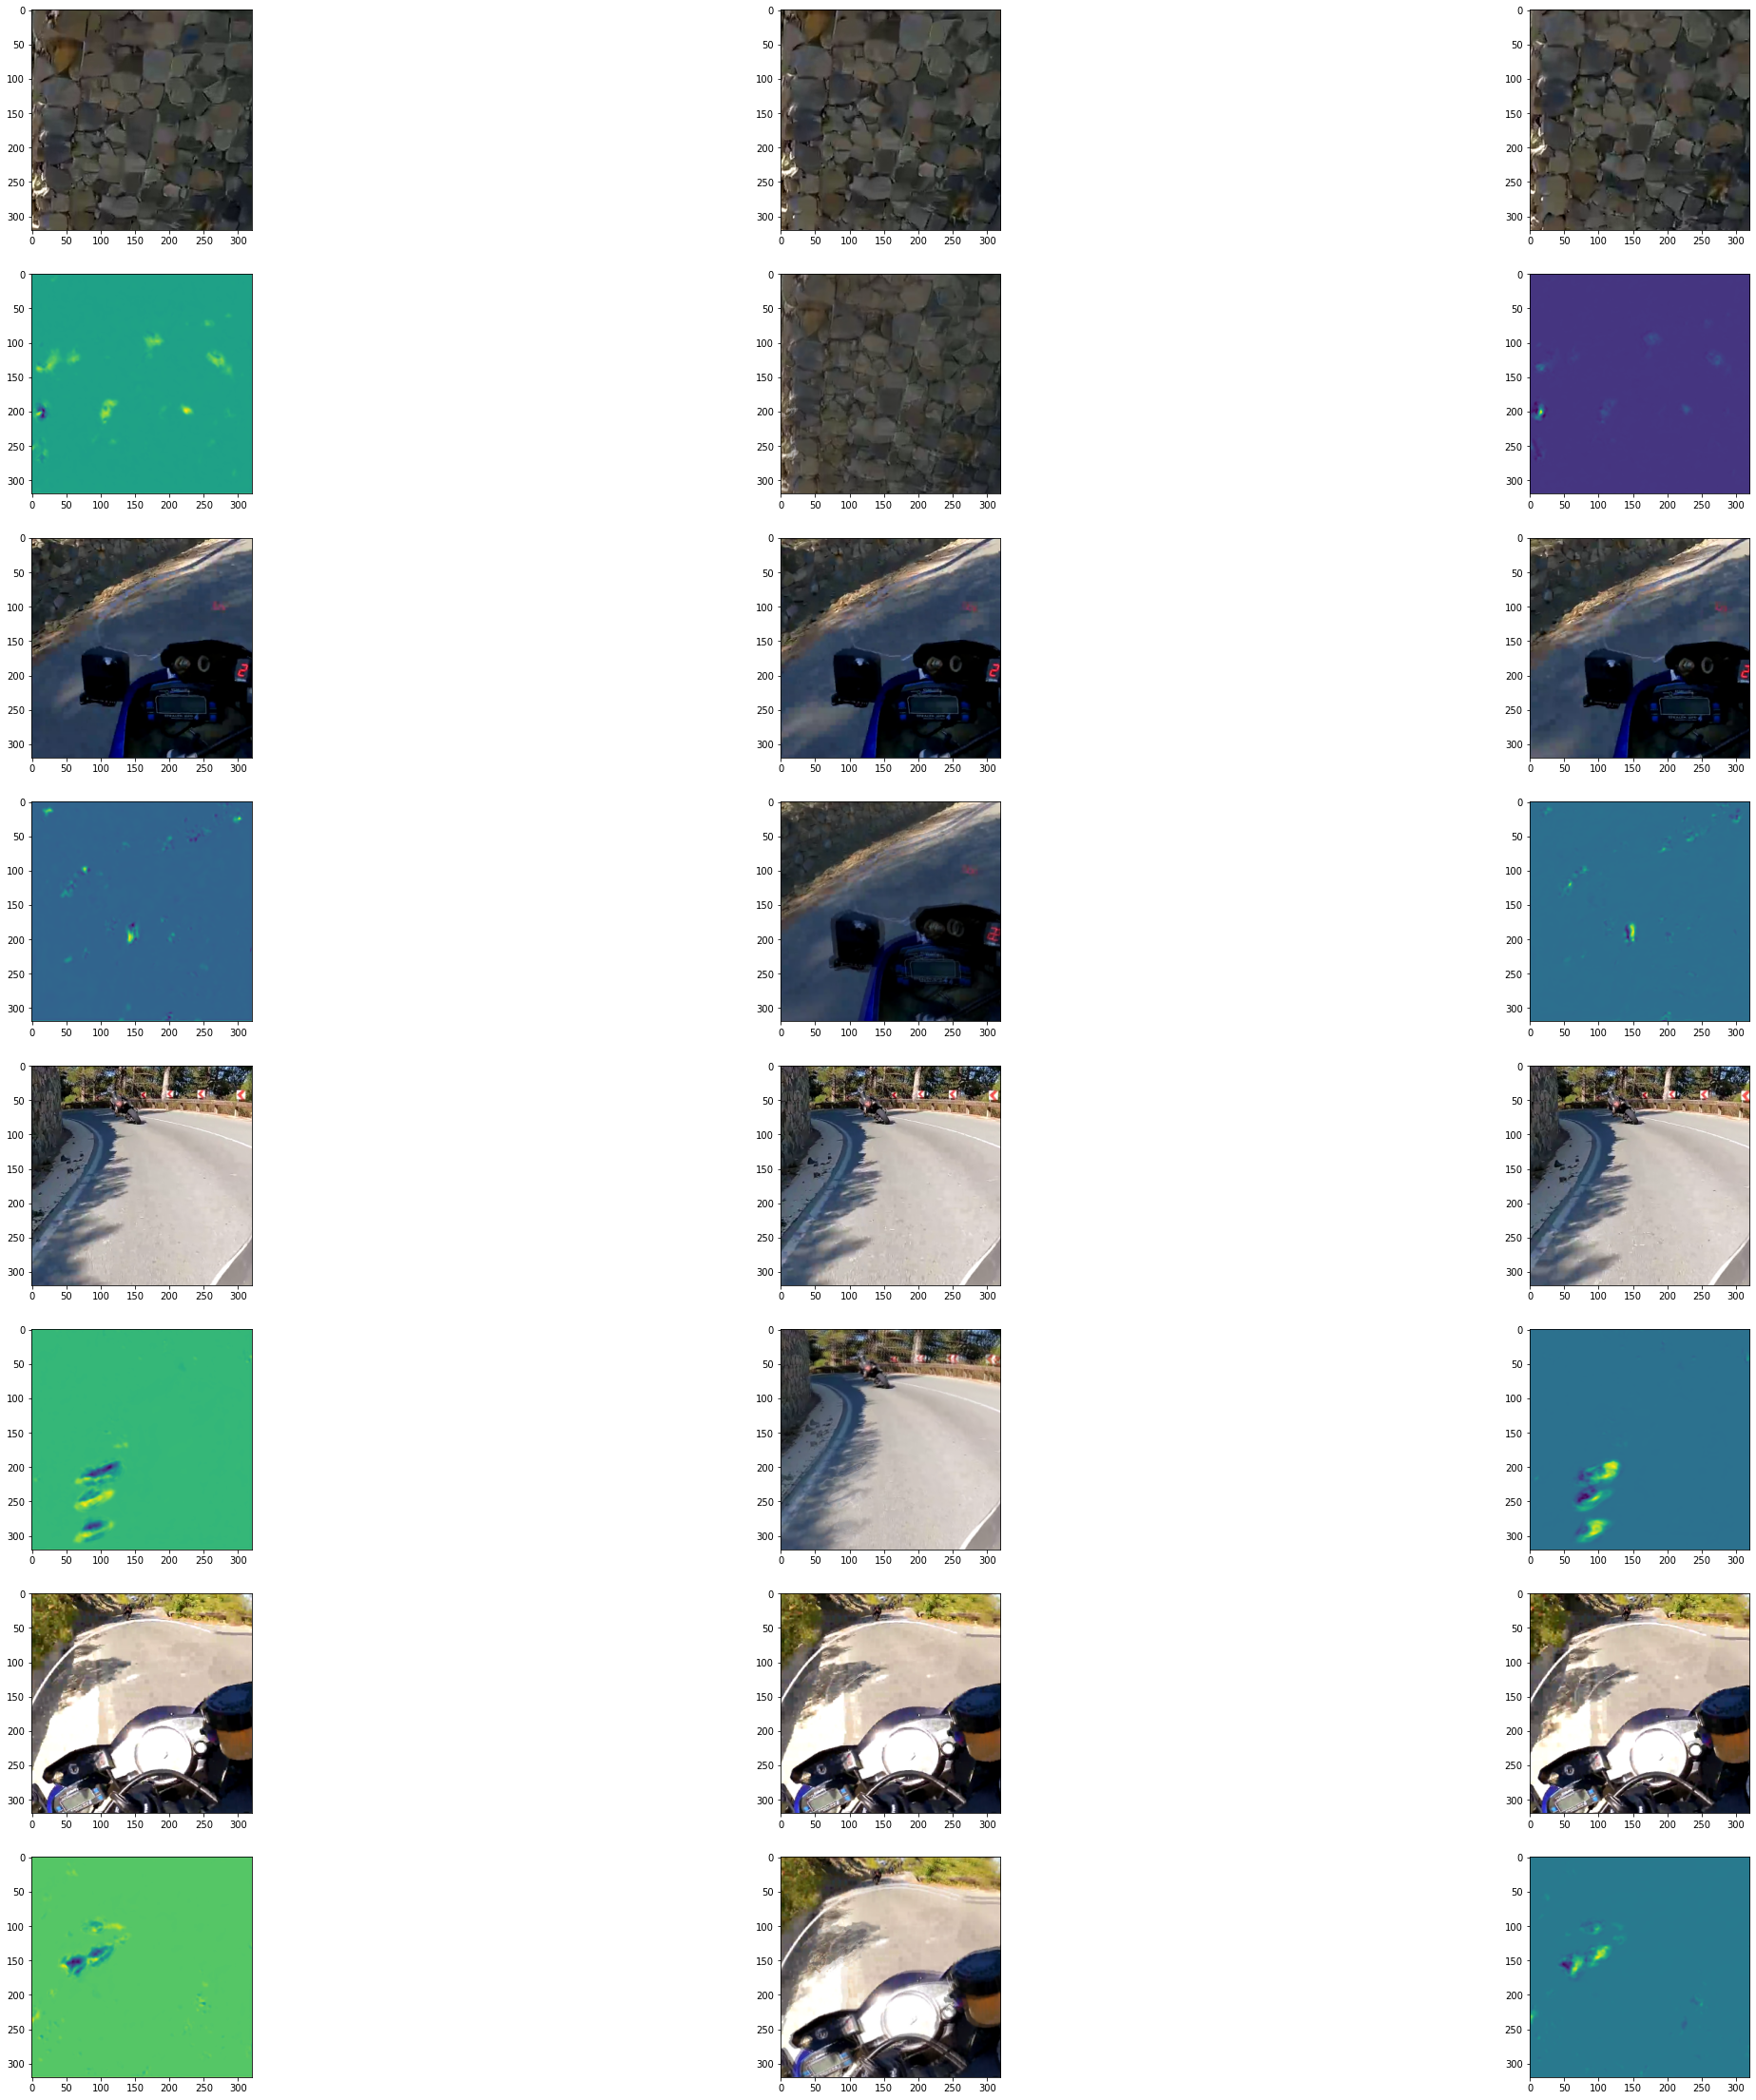

In [7]:
_ = val_ds.take(50)
samples = val_ds.take(4).as_numpy_iterator()
fig = plt.figure(figsize=(40,40))
for i in range(4):
    sample = next(samples)
    sample_x = sample[0]
    sample_y = sample[1]
    interpolated, flow = flow_model(sample_x,training=False)
    interpolated = interpolated.numpy()
    flow = flow.numpy()

    ax = fig.add_subplot(8,3,6*i+1)
    x0 = sample_x[0][...,2::-1]
    ax.imshow(x0)

    ax = fig.add_subplot(8,3,6*i+2)
    y0 = sample_y[0][...,2::-1]
    ax.imshow(y0)
    
    # ax = fig.add_subplot(8,4,8*i+3)
    # p1 = predict[0][...,5:2:-1]
    # ax.imshow(p1)

    ax = fig.add_subplot(8,3,6*i+3)
    x1 = sample_x[0][...,5:2:-1]
    ax.imshow(x1)

    ax = fig.add_subplot(8,3,6*i+4)
    fx = flow[0][...,0] +1
    ax.imshow(fx)

    ax = fig.add_subplot(8,3,6*i+5)
    p0 = interpolated[0][...,2::-1]
    ax.imshow(p0)
    
    # ax = fig.add_subplot(8,4,8*i+7)
    # y1 = sample_y[0][...,5:2:-1]
    # ax.imshow(y1)

    ax = fig.add_subplot(8,3,6*i+6)
    fy = flow[0][...,1] +1
    ax.imshow(fy)

plt.show()

In [8]:
print(np.max(flow[0]/4)*320)

18.737821578979492


In [9]:
from flow_check_model import Flow_VoxelInterp

In [10]:
fvi = Flow_VoxelInterp(interp_ratio)

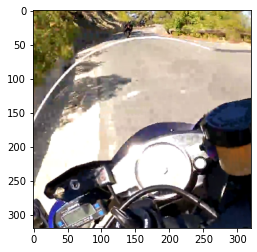

In [11]:
plt.imshow(x0)

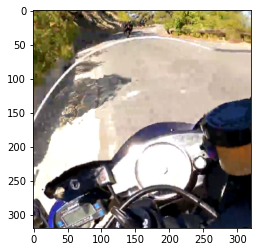

In [12]:
_, hh, ww = tf.meshgrid(
    tf.range(1, dtype=tf.float32),
    tf.linspace(tf.cast(-1,tf.float32), 1, 320),
    tf.linspace(tf.cast(-1,tf.float32), 1, 320),
    indexing='ij',
)
h0 = hh+flow[0][...,0] * 0.5
w0 = ww+flow[0][...,1] * 0.5
x0_interp = fvi.bilinear_interp(x0[np.newaxis,...], h0, w0)
plt.imshow(x0_interp[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


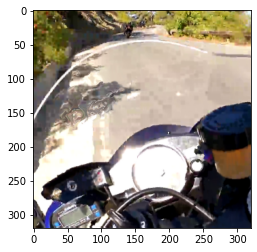

In [13]:
h1 = hh-flow[0][...,0] * 0.5
w1 = ww-flow[0][...,1] * 0.5
x1_interp = fvi.bilinear_interp(x1[np.newaxis,...], h1, w1)
plt.imshow(x1_interp[0])

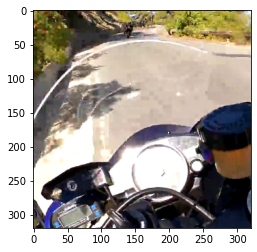

In [14]:
plt.imshow(x1)

In [15]:
gen_hh = (h1+1)*(320-1)/2
gen_ww = (w1+1)*(320-1)/2

In [16]:
diff_h = gen_hh - (hh+1)*(320-1)/2
print(tf.math.reduce_max(diff_h))

tf.Tensor(24.033127, shape=(), dtype=float32)
